In [ ]:
#yahoo finance as data source
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [ ]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-30,110.266663,111.166664,108.033333,108.366669,86.139885,7886901
2018-05-02,108.699997,110.116669,107.216667,107.900002,85.768936,13057233
2018-05-03,107.849998,109.516663,106.683334,107.716667,85.623215,10603314
2018-05-04,107.650002,110.633331,106.983330,109.916664,87.371971,8101383
2018-05-07,110.066666,114.833336,108.933334,114.599998,91.094711,14910717


In [ ]:
len(data)

1235

In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-24,108.400002,109.599998,108.400002,109.300003,109.300003,6760713
2023-04-25,109.849998,110.199997,108.750000,109.199997,109.199997,8661439
2023-04-26,109.300003,110.500000,108.599998,110.199997,110.199997,7305825
2023-04-27,110.099998,110.099998,108.800003,109.300003,109.300003,8349269
2023-04-28,109.099998,109.400002,105.050003,107.300003,107.300003,19307001


In [ ]:
opn = data[['Open']]

<Axes: xlabel='Date'>

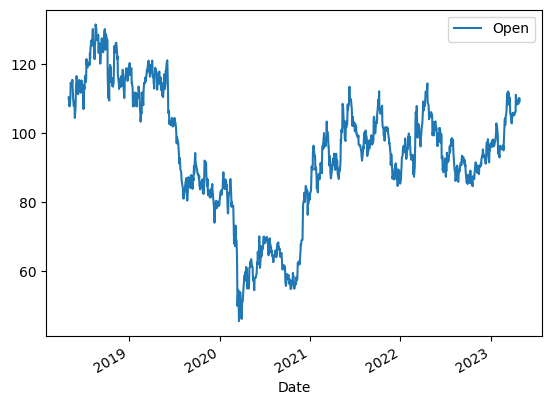

In [ ]:
opn.plot()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ds = opn.values

In [ ]:
ds

array([[110.2666626 ],
       [108.69999695],
       [107.84999847],
       ...,
       [109.30000305],
       [110.09999847],
       [109.09999847]])

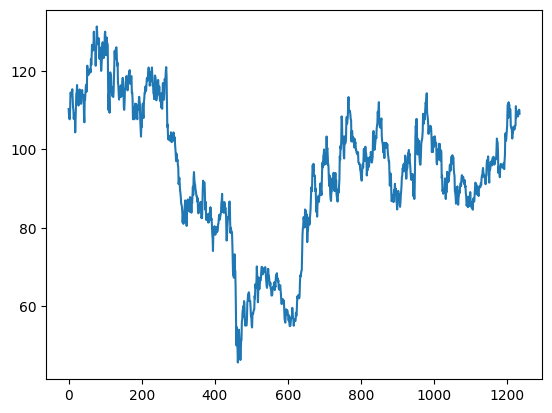

In [ ]:
plt.plot(ds)

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [ ]:
len(ds_scaled), len(ds)

(1235, 1235)

In [ ]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [ ]:
train_size,test_size

(864, 371)

In [ ]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [ ]:
len(ds_train),len(ds_test)

(864, 371)

In [ ]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [ ]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [ ]:
X_train.shape,y_train.shape

((763, 100), (763,))

In [ ]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [ ]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 13s 118ms/step - loss: 0.1115 - val_loss: 0.0072
Epoch 2/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0146 - val_loss: 0.0032
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 4/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0063 - val_loss: 0.0026
Epoch 5/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 6/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 7/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 8/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 9/100
12/12 [==============================] - 0s 26ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 10/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.00

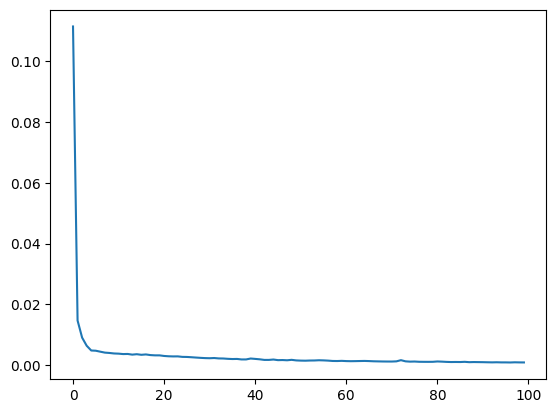

In [ ]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [ ]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 8ms/step


In [ ]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

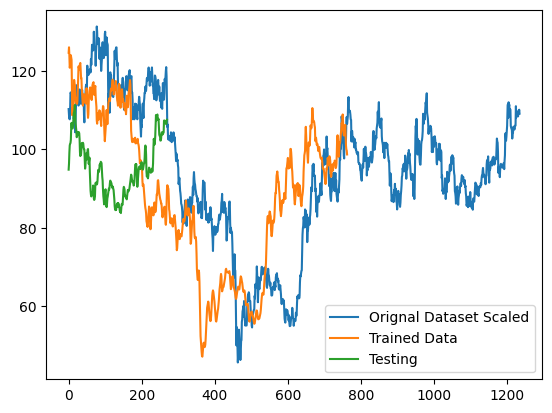

In [ ]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled), label = 'Orignal Dataset Scaled')
plt.plot(train_predict, label  ='Trained Data')
plt.plot(test_predict, label = 'Testing')
plt.legend(loc='lower right')
plt.show()

In [ ]:
type(train_predict)

numpy.ndarray

In [ ]:
test = np.vstack((train_predict,test_predict))

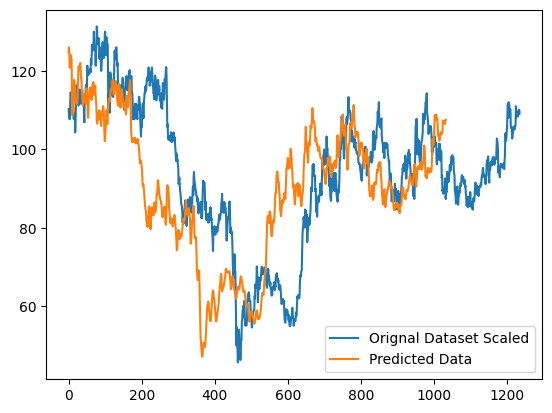

In [ ]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled), label = 'Orignal Dataset Scaled')
plt.plot(test, label = 'Predicted Data')
plt.legend(loc = 'lower right')

In [ ]:
len(ds_test)

371

In [ ]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

(1, 101)

In [ ]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
#Predicting next 30 days prices uing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7222456932067871], [0.7066910266876221], [0.689751923084259], [0.6740286946296692], [0.6601040959358215], [0.648027241230011], [0.6375809907913208], [0.6284081339836121], [0.6201152205467224], [0.6123420596122742], [0.6047987937927246], [0.5972779393196106], [0.5896521210670471], [0.581860363483429], [0.5738916397094727], [0.565767765045166], [0.5575269460678101], [0.5492122769355774], [0.5408626794815063], [0.5325082540512085], [0.5241677165031433], [0.5158488750457764], [0.5075497031211853], [0.499260812997818], [0.4909675419330597], [0.4826519787311554], [0.474295049905777], [0.46587762236595154], [0.45738130807876587], [0.4487893283367157]]


In [ ]:
len(ds_scaled)

1235

In [ ]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

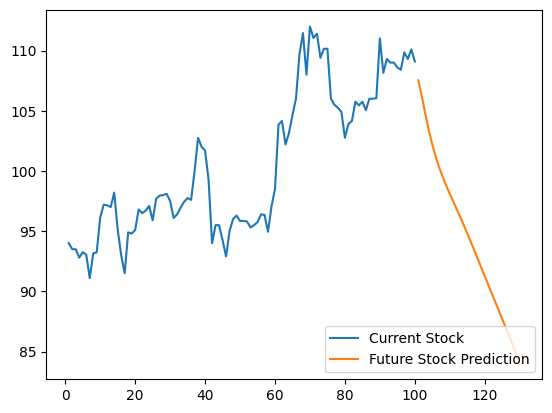

In [ ]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1135:]), label = 'Current Stock')
plt.plot(plot_pred, normalizer.inverse_transform(lst_output), label = 'Future Stock Prediction')
plt.legend(loc = 'lower right')

In [ ]:
ds_new = ds_scaled.tolist()

In [ ]:
len(ds_new)

1235

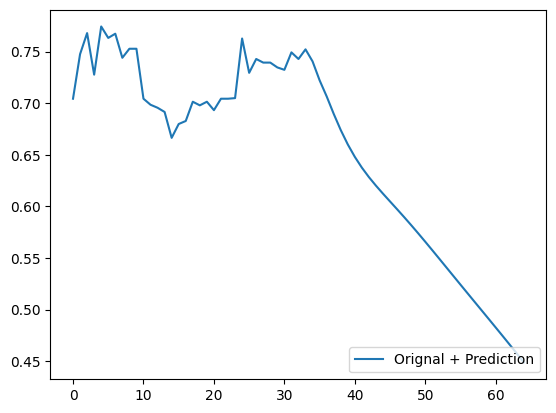

In [ ]:
#Extend helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:], label = 'Orignal + Prediction')
plt.legend (loc = 'lower right')

In [ ]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

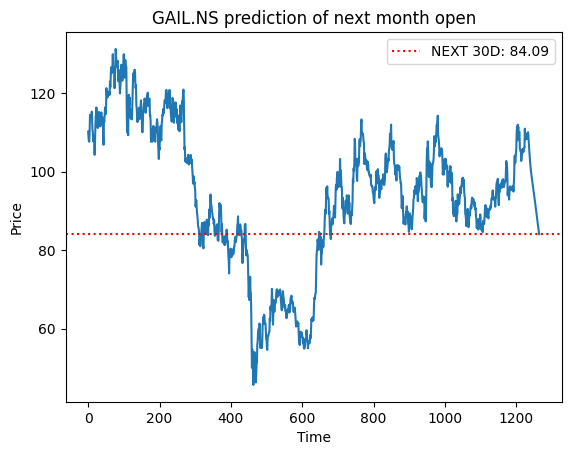

In [ ]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()